In [3]:
import django, os, sys, time, resource, re, gc, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from django.db.models import Count, Avg, F

sys.path.append('/home/galm/software/django/tmv/BasicBrowser/')

os.environ.setdefault("DJANGO_SETTINGS_MODULE", "BasicBrowser.settings")
django.setup()

from scoping.models import *

In [10]:
p = Project.objects.get(title="NETs")
pdocs = Doc.objects.filter(query__project=p) | Doc.objects.filter(technology__project=p)

trdocs = set(list(pdocs.filter(docownership__relevant=1).values_list('UT',flat=True)))

irdocs = set(list(pdocs.filter(docownership__relevant=5).values_list('UT',flat=True)))


In [15]:
print(len(trdocs))
print(len(irdocs))

allreldocs = pdocs.distinct().filter(
    UT__in=trdocs.intersection(irdocs)
)

print(allreldocs.count())

1777
1792
675


In [14]:
len(trdocs.intersection(irdocs))

675

In [58]:
allidocs = pdocs.distinct().filter(
    docownership__relevant=5,
).values('PY','docownership__query__innovation__name').annotate(
    n = Count('pk', distinct = True)
)
df = pd.DataFrame.from_dict(list(allidocs))
df.head()

,PY,docownership__query__innovation__name,n
0,2013,Demos,8
1,2002,RD,22
2,2016,Demos,10
3,2010,Demos,3
4,1992,RD,5


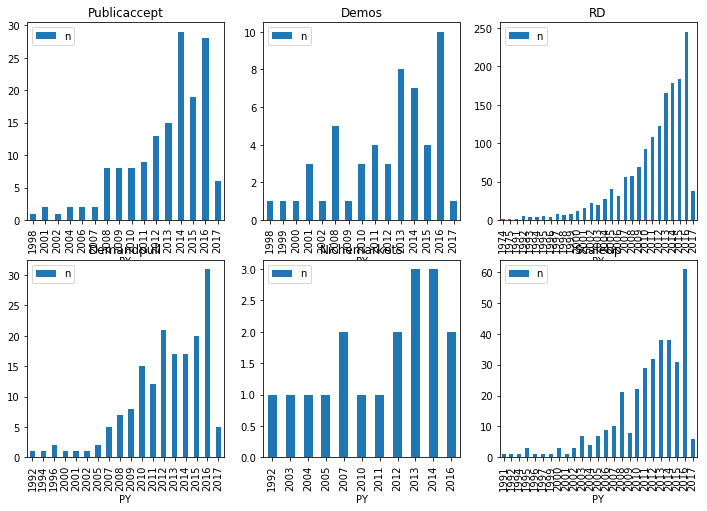

In [110]:
plt.rcParams["figure.figsize"] = [12,8]

fig, axs = plt.subplots(nrows=2,ncols=3)

grouped =  df.groupby('docownership__query__innovation__name')

targets = zip(grouped.groups.keys(), axs.flatten())

for i, (key, ax) in enumerate(targets):
    group = grouped.get_group(key)
    group = group.sort_values('PY')
    group = group.set_index('PY')
    ax = group.plot.bar(ax=ax)
    #ax.bar(group.index,group['n'])
    #ax.bar(group,group[['n']])
    ax.set_title(key)
    

plt.savefig('plots/1_1_1.png',bbox_inches='tight') 
plt.show()

In [109]:
allds = allreldocs.filter(
    docownership__relevant__in=[5,1],
).values(
    'docownership__query__innovation__name',
    'docownership__query__technology__name',
    'PY'
).annotate(
    n = Count('pk', distinct = True)
)
adf = pd.DataFrame.from_dict(list(allds))
adf = adf[adf['docownership__query__innovation__name'] != "None"]
adf.head()

,PY,docownership__query__innovation__name,docownership__query__technology__name,n
0,2005,None,Synonyms,1
1,2008,Publicaccept,Ocean fertilisation,5
2,2015,Scaleup,Direct Air Capture,2
3,2013,Publicaccept,Soil Carbon Sequestration,2
4,2006,None,BECCS,1


docownership__query__innovation__name
docownership__query__technology__name
0
1
2
3
4
5


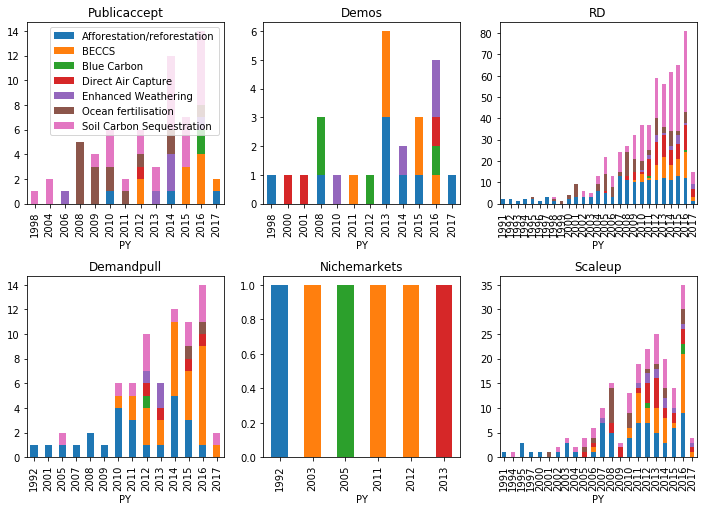

docownership__query__technology__name
docownership__query__innovation__name
0
1
2
3
4
5
6
7
Ocean Alkalinisation
       PY docownership__query__innovation__name  \
231  2007                                  None   
366  2012                                  None   
108  2013                                  None   
394  2014                                  None   
352  2015                                  None   
117  2016                                  None   

    docownership__query__technology__name  n  
231                  Ocean Alkalinisation  1  
366                  Ocean Alkalinisation  1  
108                  Ocean Alkalinisation  4  
394                  Ocean Alkalinisation  1  
352                  Ocean Alkalinisation  1  
117                  Ocean Alkalinisation  1  
8
Synonyms
       PY docownership__query__innovation__name  \
23   2003                                  None   
0    2005                                  None   
244  2006                           

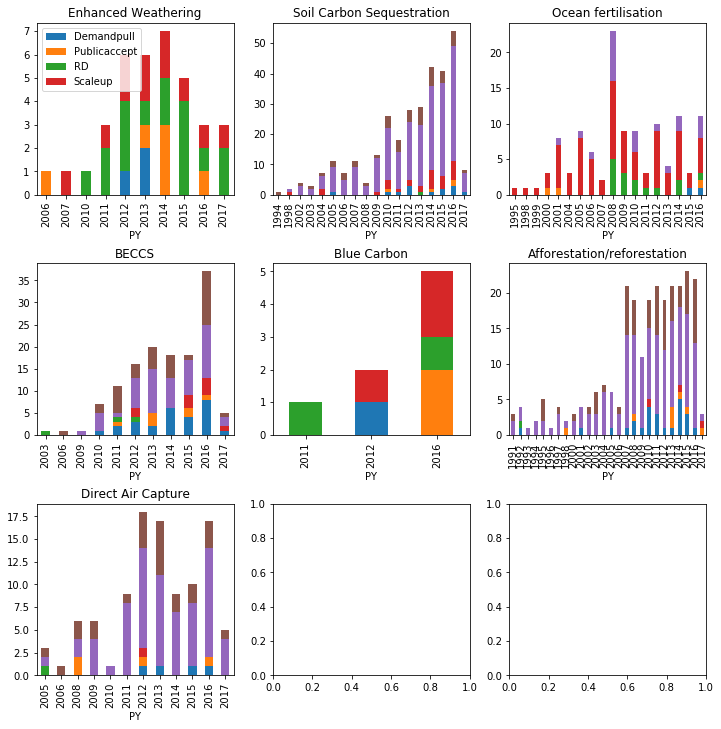

In [113]:
groupings = [
    ('docownership__query__innovation__name','docownership__query__technology__name',2),
    ('docownership__query__technology__name','docownership__query__innovation__name',3),
]


for x in groupings:
    
    plt.rcParams["figure.figsize"] = [12,4*x[2]]
    
    print(x[0])

    print(x[1])
    
    grouped = adf.groupby(x[0])

    fig, axs = plt.subplots(nrows=x[2],ncols=3,gridspec_kw=dict(hspace=0.4))
    targets = zip(grouped.groups.keys(), axs.flatten())

    for i, (key, ax) in enumerate(targets):
        print(i)
        try:
            group = grouped.get_group(key)
            group = group.sort_values('PY')

            table = pd.pivot_table(
                group,
                values='n',
                columns=[x[1]],
                index=['PY']
            )

            table.plot.bar(ax=ax,stacked=True,legend=False,title=key)

            if i == 0:
                ax.legend()
            #group.plot.bar()
        except:
            print(key)
            print(group)
            pass

    #ax.legend()
    plt.savefig('plots/1_1_{}.png'.format(x[2]),bbox_inches='tight') 
    plt.show()